<a href="https://colab.research.google.com/github/AnnyNny/population_classification/blob/main/Russian_population_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas
import zipfile
import urllib.request
import plotnine
from subprocess import Popen

In [ ]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

## Скачаем данные

### Скачаем архив

In [ ]:
data_url = "http://www.russiangenome.ru/biengi.zip"
data_zip = os.path.join(data_dir, "plink_data.zip")

urllib.request.urlretrieve(data_url, data_zip)

('data/plink_data.zip', <http.client.HTTPMessage at 0x7e9cb7552750>)

### Распакуем архив

In [ ]:
with zipfile.ZipFile(data_zip, 'r') as zipped_datafile:
    zipped_datafile.extractall(data_dir)

### Получим путь к данным

In [ ]:
data_prefix = [os.path.splitext(os.path.join(data_dir, file))[0] for file in os.listdir(data_dir) if file.endswith('.bed')][0]

## Скачаем plink

In [ ]:
%%bash
URL64BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20200121.zip"
URL32BIT="http://s3.amazonaws.com/plink1-assets/plink_linux_i686_20200121.zip"

# Измените версию если нужно
URL=$URL64BIT

wget -q $URL -O plink.zip
unzip -q -n plink.zip plink

## Определим функции для работы с plink

In [ ]:
def prune_data(plink_prefix, out_prefix):
    cmd = ['./plink', '--bfile', plink_prefix,
           '--indep', '50', '5', '2', '--out', out_prefix
    ]
    prune_result = out_prefix + '.prune.in'
    assert Popen(cmd).wait() == 0

    cmd = ['./plink', '--bfile', plink_prefix, '--extract', prune_result,
           '--make-bed', '--out', out_prefix
    ]
    assert Popen(cmd).wait() == 0

    return

def pca_plink(plink_prefix, out_prefix, n_components=20):
    # Perform PCA using plink
    cmd = ['./plink', '--pca', str(n_components), '--autosome']
    cmd += ['--bfile', plink_prefix, '--out', out_prefix]

    assert Popen(cmd).wait() == 0

    return out_prefix + '.eigenvec', out_prefix + '.eigenval'

def plot_pca(df, dim=2):
    size=5
    symbol='cicle',
    opacity=1.
    if dim == 2:
        scatter = go.Scatter(
            visible=True,
            name=name,
            x=df.loc[:, 0],
            y=df.loc[:, 1],
            text=[(name, indiv) for _, indiv in zip(
                range(df.loc[:, cols[0]].shape[0]), point_names)],
            textposition='middle right',
            mode='markers',
            marker=dict(size=size, opacity=opacity, symbol=symbol))
    elif dim == 3:
        scatter = go.Scatter3d(
            visible=True,
            name=name,
            x=df.loc[:, 0],
            y=df.loc[:, 1],
            z=df.loc[:, 2],
            text=[(name, indiv) for _, indiv in zip(
                range(df.loc[:, cols[0]].shape[0]), point_names)],
            textposition='middle right',
            mode='markers',
            marker=dict(size=size, opacity=opacity, symbol=symbol))
    return scatter


# Посторим PCA

## Запустим прунинг

In [ ]:
pruned_data = data_prefix + '_pruned'
prune_data(data_prefix, pruned_data)

## Запустим PCA

In [ ]:
pca_prefix = pruned_data + '_pruned'
pca_eigenvec, pca_eigenval = pca_plink(pruned_data, pca_prefix)

## Нарисуем PCA

### Прочитаем популяции

In [ ]:
pop_filename = data_prefix + ".pedind"
pop_df = pandas.read_csv(pop_filename, sep="\s+", header=None, usecols = [0, 1, 5],
                        names=['FID', 'IID', 'Population'])

pop_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1471873661.py:2: SyntaxWarning: invalid escape sequence '\s'


,FID,IID,Population
0,4461875510_R01C01,4461875510_R01C01,Karel
1,4461875510_R01C02,4461875510_R01C02,Karel
2,4461875510_R02C01,4461875510_R02C01,Karel
3,4461875513_R02C02,4461875513_R02C02,Karel
4,4461875513_R01C02,4461875513_R01C02,Karel


### Прочитаем результаты PCA

In [ ]:
eigenvec_df = pandas.read_csv(pca_eigenvec, sep="\s+", header=None)
eigenvec_df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1873964123.py:1: SyntaxWarning: invalid escape sequence '\s'


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.005069,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.004695,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,-0.000110,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,-0.013387,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.013590,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286


In [ ]:
merge_df = pandas.merge(eigenvec_df, pop_df, left_on=[0, 1], right_on=['FID', 'IID'])
merge_df = merge_df.drop(columns=[0,1])
merge_df.rename(columns={ merge_df.columns[0]: "pc1",
                          merge_df.columns[1]: "pc2",
                          merge_df.columns[2]: "pc3"}, inplace = True)
merge_df.head()

,pc1,pc2,pc3,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,FID,IID,Population
0,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,-0.073206,0.037070,...,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613,4461875510_R01C01,4461875510_R01C01,Karel
1,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,-0.014171,-0.014982,...,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745,4461875510_R01C02,4461875510_R01C02,Karel
2,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,-0.101528,0.038745,...,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078,4461875510_R02C01,4461875510_R02C01,Karel
3,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,-0.090599,0.039748,...,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287,4461875513_R02C02,4461875513_R02C02,Karel
4,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,-0.083010,0.035734,...,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286,4461875513_R01C02,4461875513_R01C02,Karel


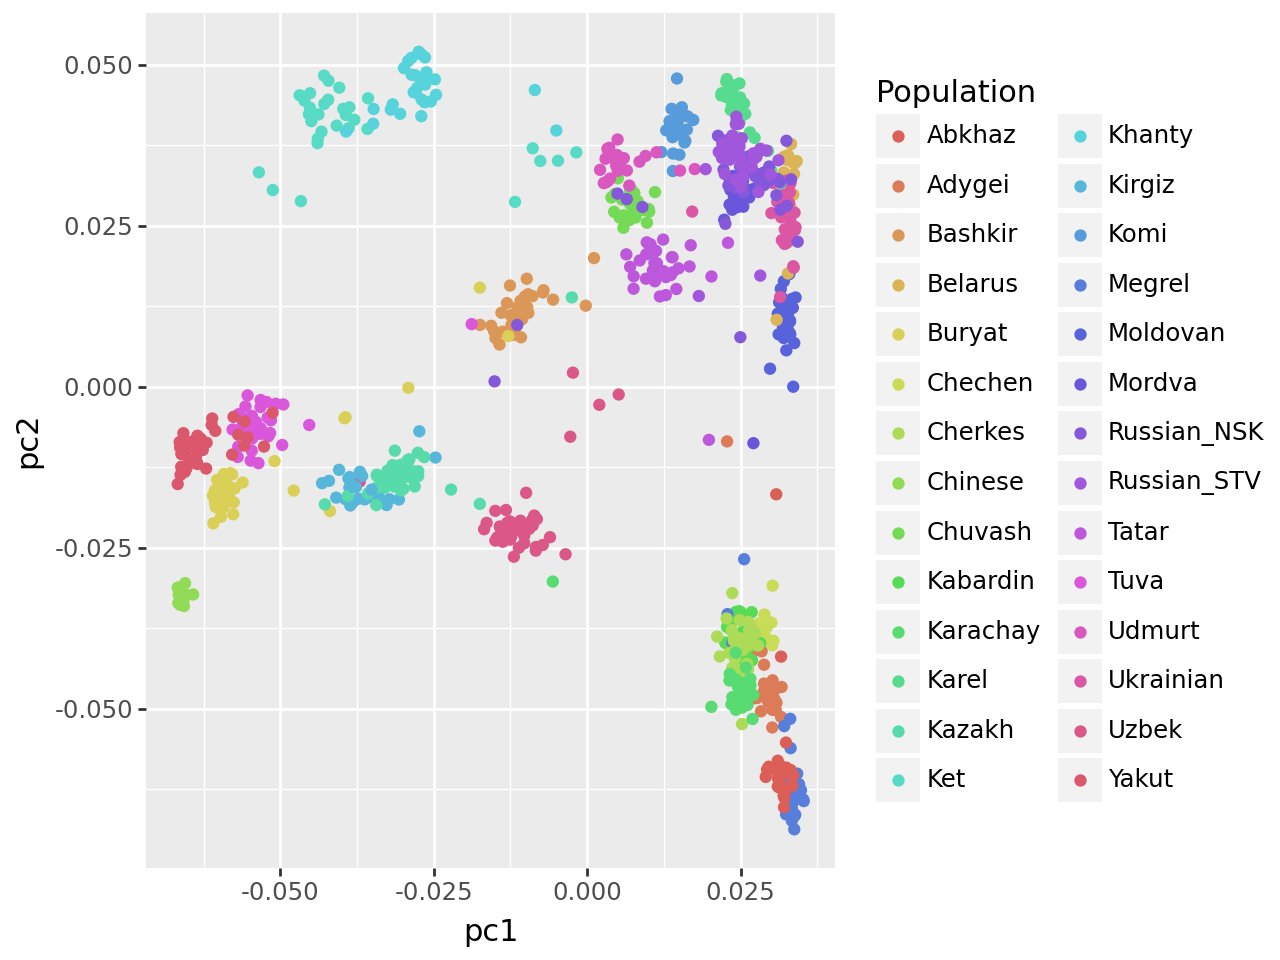

In [ ]:
plotnine.ggplot(merge_df) + plotnine.aes(x="pc1", y="pc2", color='Population') + plotnine.geom_point()

In [ ]:
import os, pathlib
print("Before:", os.getcwd())
os.chdir("/content/data")  # adjust if your path differs
print("Now in:", os.getcwd())

# sanity check
!ls -lh


Before: /content
Now in: /content/data
total 118M
-rw-r--r-- 1 root root  52M Sep 15 22:55 biengi.bed
-rw-r--r-- 1 root root 6.4M Sep 15 22:55 biengi.bim
-rw-r--r-- 1 root root  38K Sep 15 22:55 biengi.fam
-rw-r--r-- 1 root root  42K Sep 15 22:55 biengi.pedind
-rw-r--r-- 1 root root  22M Sep 15 22:55 biengi_pruned.bed
-rw-r--r-- 1 root root 2.7M Sep 15 22:55 biengi_pruned.bim
-rw-r--r-- 1 root root  38K Sep 15 22:55 biengi_pruned.fam
-rw-r--r-- 1 root root  884 Sep 15 22:55 biengi_pruned.log
-rw-r--r-- 1 root root  159 Sep 15 22:55 biengi_pruned_pruned.eigenval
-rw-r--r-- 1 root root 219K Sep 15 22:55 biengi_pruned_pruned.eigenvec
-rw-r--r-- 1 root root  872 Sep 15 22:55 biengi_pruned_pruned.log
-rw-r--r-- 1 root root 969K Sep 15 22:55 biengi_pruned.prune.in
-rw-r--r-- 1 root root 1.4M Sep 15 22:55 biengi_pruned.prune.out
-rw-r--r-- 1 root root  34M Sep 15 22:55 plink_data.zip


In [ ]:
import pandas as pd

pedind = pd.read_csv(
    "biengi.pedind",
    sep="\t",
    header=None,
    names=["Family_ID","Individual_ID","Paternal_ID","Maternal_ID","Sex","Group"]
)
print("pedind shape:", pedind.shape)
print("unique groups:", len(pedind["Group"].unique()))
display(pedind["Group"].value_counts().head(30))
pedind.head()


pedind shape: (894, 6)
unique groups: 28


,count
Group,
Kazakh,45
Tuva,44
Buryat,44
Yakut,41
Russian_STV,39
Uzbek,39
Russian_NSK,38
Megrel,36
Kabardin,35


,Family_ID,Individual_ID,Paternal_ID,Maternal_ID,Sex,Group
0,4461875510_R01C01,4461875510_R01C01,0,0,1,Karel
1,4461875510_R01C02,4461875510_R01C02,0,0,1,Karel
2,4461875510_R02C01,4461875510_R02C01,0,0,1,Karel
3,4461875513_R02C02,4461875513_R02C02,0,0,1,Karel
4,4461875513_R01C02,4461875513_R01C02,0,0,1,Karel


In [ ]:
EIGENVEC = "/content/data/biengi_pruned_pruned.eigenvec"

ev = pd.read_csv(EIGENVEC, sep=r"\s+", header=None)
n_cols = ev.shape[1]
pc_cols = [f"PC{i}" for i in range(1, n_cols-1)]  # минус FID/IID

ev.columns = ["FID", "IID"] + pc_cols
print("eigenvec shape:", ev.shape, "| PCs:", len(pc_cols))
ev.head()


eigenvec shape: (894, 22) | PCs: 20


,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,4461875510_R01C01,4461875510_R01C01,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.005069,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613
1,4461875510_R01C02,4461875510_R01C02,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.004695,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745
2,4461875510_R02C01,4461875510_R02C01,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,-0.000110,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078
3,4461875513_R02C02,4461875513_R02C02,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,-0.013387,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287
4,4461875513_R01C02,4461875513_R01C02,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.013590,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286


In [ ]:
import pandas as pd

# paths
PEDIND_PATH = "/content/data/biengi.pedind"  # adjust if different
# you already defined: ev (has FID, IID, PC1..PC20) and pc_cols list

# load labels
pedind = pd.read_csv(
    PEDIND_PATH, sep="\t", header=None,
    names=["Family_ID","Individual_ID","Paternal_ID","Maternal_ID","Sex","Group"]
)

# merge by IID ↔ Individual_ID
df = ev.merge(pedind[["Individual_ID","Group"]],
              left_on="IID", right_on="Individual_ID", how="inner")
print("Merged shape:", df.shape, "| groups:", df["Group"].nunique())
df[["IID","Group"] + pc_cols[:]].head()


Merged shape: (894, 24) | groups: 28


,IID,Group,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,4461875510_R01C01,Karel,0.023656,0.044685,0.024901,-0.012835,-0.009770,0.006716,-0.010370,0.006021,...,0.005069,0.051467,-0.010690,-0.035015,-0.095092,0.014845,-0.033535,-0.013700,0.036779,0.001613
1,4461875510_R01C02,Karel,0.029982,0.033608,0.032103,-0.014175,-0.004904,0.022838,-0.003047,0.004947,...,-0.004695,-0.001433,-0.029270,-0.019349,-0.020024,-0.011725,0.016307,0.008480,-0.009798,0.005745
2,4461875510_R02C01,Karel,0.025548,0.043980,0.023810,-0.012104,-0.004047,0.016872,-0.007012,0.017078,...,-0.000110,0.040661,-0.025415,-0.024280,-0.135829,0.018732,-0.032434,-0.039587,0.028321,0.034078
3,4461875513_R02C02,Karel,0.022953,0.045839,0.024924,-0.015718,-0.011845,0.007434,-0.018396,0.024504,...,-0.013387,0.026770,-0.036955,-0.028485,-0.125899,0.049872,-0.016697,-0.007108,0.016528,0.005287
4,4461875513_R01C02,Karel,0.024415,0.043405,0.018632,-0.004825,-0.007012,0.008693,-0.011580,0.011086,...,0.013590,0.035081,-0.020707,-0.024508,-0.139401,0.012883,-0.033515,-0.008684,0.042671,-0.008286


In [ ]:
print("Всего групп:", df["Group"].nunique())
print("Примеры:", df["Group"].unique()[:10])  # первые 10 названий
display(df["Group"].value_counts().head(20))  # сколько людей в каждой группе (топ-20)


Всего групп: 28
Примеры: ['Karel' 'Moldovan' 'Tatar' 'Bashkir' 'Mordva' 'Chuvash' 'Ukrainian'
 'Belarus' 'Chechen' 'Adygei']


,count
Group,
Kazakh,45
Tuva,44
Buryat,44
Yakut,41
Russian_STV,39
Uzbek,39
Russian_NSK,38
Megrel,36
Kabardin,35


In [ ]:
group_means = df.groupby("Group")[pc_cols].mean()
print("Форма:", group_means.shape)
group_means.head()


Форма: (28, 20)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Group,,,,,,,,,,,,,,,,,,,,
Abkhaz,0.031622,-0.058212,-0.025333,0.001820,-0.009293,0.000351,-0.008472,0.005862,-0.007090,-0.001388,-0.001996,0.018928,-0.012499,0.003979,0.000028,0.005199,-0.048195,0.012164,-0.012510,0.006098
Adygei,0.028975,-0.046002,-0.020011,0.000782,-0.007429,0.002256,-0.008944,0.000190,-0.003817,0.006176,0.003824,0.052935,-0.050083,-0.026937,0.026526,-0.000534,0.087121,-0.012603,0.040026,-0.011629
Bashkir,-0.010871,0.011574,-0.003718,0.025520,0.011755,-0.003960,0.021061,-0.018722,0.033408,0.062173,0.008364,-0.080397,-0.096146,0.001719,0.013439,0.016117,-0.020704,-0.005900,-0.000484,-0.001712
Belarus,0.032647,0.031262,0.028757,-0.024642,-0.000169,0.021173,0.000089,0.001374,0.019796,-0.032334,-0.003422,-0.006903,-0.002071,-0.003249,0.014625,-0.002380,0.012466,0.007616,-0.003407,0.014309
Buryat,-0.054696,-0.014267,0.033180,0.000186,0.029031,0.006437,-0.116379,-0.013238,0.007579,0.002068,0.003087,-0.001520,0.003887,0.002336,0.001774,0.004207,-0.000016,0.000837,-0.000811,0.000451


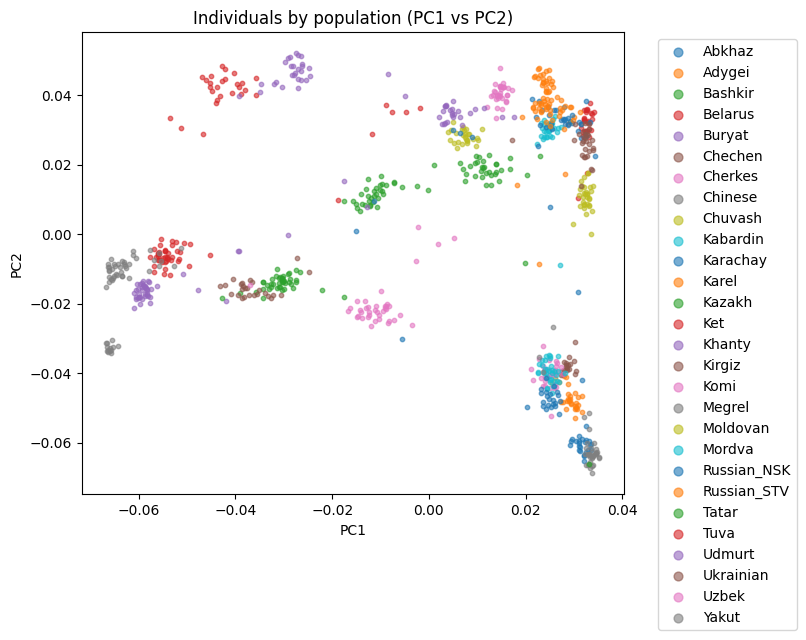

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
for grp, sub in df.groupby("Group"):
    plt.scatter(sub["PC1"], sub["PC2"], s=10, alpha=0.6, label=grp)

plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Individuals by population (PC1 vs PC2)")
plt.show()


In [ ]:
import numpy as np

eigvals = pd.read_csv("/content/data/biengi_pruned_pruned.eigenval", header=None)
var_explained = eigvals[0] / eigvals[0].sum()
print("PC1:", var_explained.iloc[0], "PC2:", var_explained.iloc[1])
print("Cumulative (PC1+PC2):", var_explained.iloc[:2].sum())


PC1: 0.43140156000375907 PC2: 0.09913850202048681
Cumulative (PC1+PC2): 0.5305400620242459


In [ ]:
group_means = df.groupby("Group")[["PC1","PC2"]].mean()
display(group_means.head(10))


,PC1,PC2
Group,,
Abkhaz,0.031622,-0.058212
Adygei,0.028975,-0.046002
Bashkir,-0.010871,0.011574
Belarus,0.032647,0.031262
Buryat,-0.054696,-0.014267
Chechen,0.028750,-0.037949
Cherkes,0.024895,-0.040272
Chinese,-0.065958,-0.032640
Chuvash,0.008028,0.028323


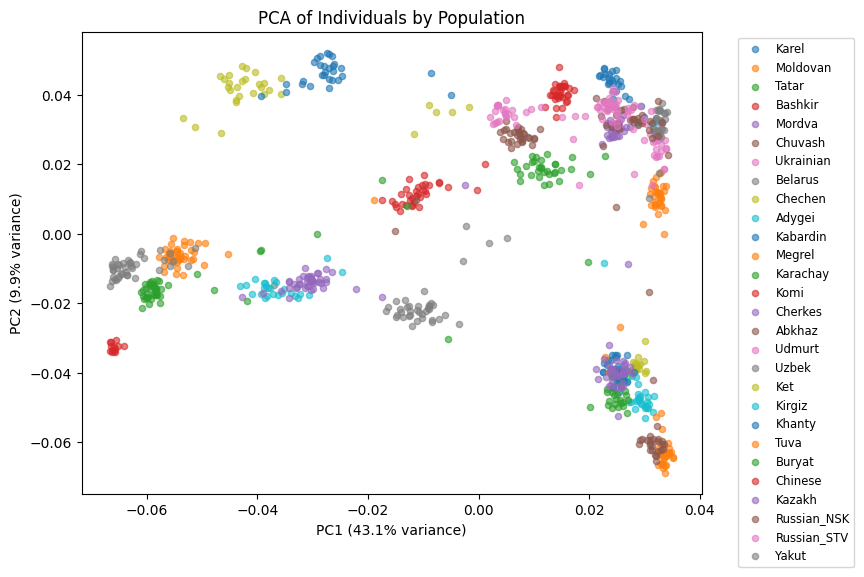

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for g in df["Group"].unique():
    subset = df[df["Group"] == g]
    plt.scatter(subset["PC1"], subset["PC2"], label=g, alpha=0.6, s=20)

plt.xlabel(f"PC1 ({var_explained.iloc[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({var_explained.iloc[1]*100:.1f}% variance)")
plt.title("PCA of Individuals by Population")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.show()


In [ ]:
# --- Классификация по группам на основе PCA ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 1) Данные
X = df[pc_cols].values   # признаки (PC1..PC20)
y = df["Group"].values   # целевая переменная (группа)

# 2) Закодируем группы как числа
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 3) Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Разобьём на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 5) Модели
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, multi_class="multinomial"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42)
}

# 6) Кросс-валидация
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_enc, cv=5, scoring="accuracy")
    print(f"{name}: mean accuracy = {scores.mean():.3f} ± {scores.std():.3f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always 

LogisticRegression: mean accuracy = 0.803 ± 0.027
RandomForest: mean accuracy = 0.875 ± 0.014
SVM: mean accuracy = 0.821 ± 0.028


In [ ]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, multi_class="multinomial"))
scores = cross_val_score(model, X, y_enc, cv=5, scoring="accuracy")
print(scores.mean())


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always 

0.79976774841504


In [ ]:
# --- Leak-free cross-validation with Pipelines on PC features ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# X = df[pc_cols].values   # you already have df and pc_cols
# y = df["Group"].values

X = df[pc_cols].to_numpy(dtype="float32")
le = LabelEncoder()
y = le.fit_transform(df["Group"].to_numpy())

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipelines (scaler is *inside* the CV)
pipe_lr  = make_pipeline(StandardScaler(), LogisticRegression(max_iter=4000, multi_class="multinomial", solver="saga"))
pipe_svm = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True))
rf       = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)  # trees don't need scaling

for name, model in {
    "LogReg (multinomial)": pipe_lr,
    "SVM (RBF)":            pipe_svm,
    "RandomForest":         rf,
}.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")


LogReg (multinomial): 0.801 ± 0.012
SVM (RBF): 0.819 ± 0.021
RandomForest: 0.881 ± 0.022


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



=== LogReg (multinomial) ===
              precision    recall  f1-score   support

      Abkhaz       0.67      0.80      0.73         5
      Adygei       1.00      0.83      0.91         6
     Bashkir       1.00      1.00      1.00         7
     Belarus       0.56      0.83      0.67         6
      Buryat       1.00      0.89      0.94         9
     Chechen       1.00      1.00      1.00         3
     Cherkes       0.40      0.29      0.33         7
     Chinese       1.00      1.00      1.00         2
     Chuvash       1.00      1.00      1.00         6
    Kabardin       0.55      0.86      0.67         7
    Karachay       1.00      0.50      0.67         4
       Karel       1.00      1.00      1.00         5
      Kazakh       0.64      0.78      0.70         9
         Ket       1.00      1.00      1.00         6
      Khanty       1.00      1.00      1.00         6
      Kirgiz       0.50      0.33      0.40         6
        Komi       1.00      0.83      0.91        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



=== RandomForest ===
              precision    recall  f1-score   support

      Abkhaz       1.00      1.00      1.00         5
      Adygei       1.00      0.83      0.91         6
     Bashkir       1.00      1.00      1.00         7
     Belarus       0.56      0.83      0.67         6
      Buryat       1.00      0.89      0.94         9
     Chechen       1.00      1.00      1.00         3
     Cherkes       0.67      0.86      0.75         7
     Chinese       1.00      1.00      1.00         2
     Chuvash       1.00      1.00      1.00         6
    Kabardin       0.83      0.71      0.77         7
    Karachay       1.00      0.75      0.86         4
       Karel       1.00      0.80      0.89         5
      Kazakh       0.80      0.89      0.84         9
         Ket       1.00      1.00      1.00         6
      Khanty       1.00      1.00      1.00         6
      Kirgiz       0.75      0.50      0.60         6
        Komi       1.00      1.00      1.00         6
     

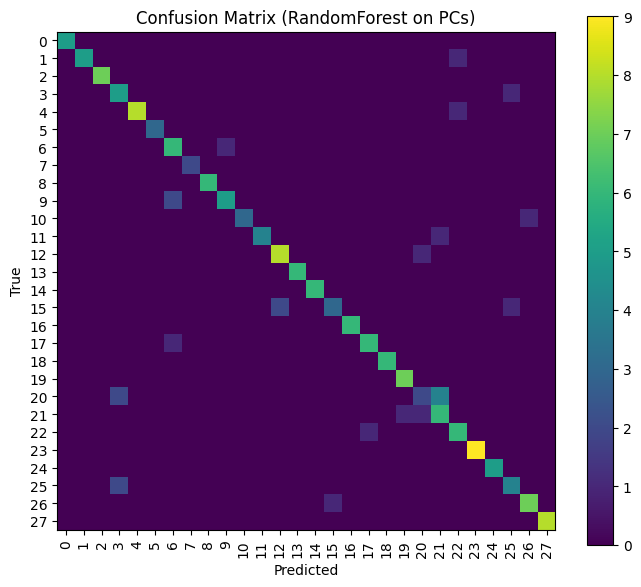

In [ ]:
# --- Proper train/test evaluation with Pipelines and confusion matrix ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe_lr  = make_pipeline(StandardScaler(), LogisticRegression(max_iter=4000, multi_class="multinomial", solver="saga"))
pipe_svm = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True))
rf       = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)

models = {
    "LogReg (multinomial)": pipe_lr,
    "SVM (RBF)":            pipe_svm,
    "RandomForest":         rf,
}

for name, model in models.items():
    model.fit(X_train, y_train)                # scaler fits on TRAIN only
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix for the best model (choose one; here RandomForest)
best = rf
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (RandomForest on PCs)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(np.arange(len(le.classes_)), np.arange(len(le.classes_)), rotation=90)
plt.yticks(np.arange(len(le.classes_)), np.arange(len(le.classes_)))
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Логистическая регрессия
logreg = LogisticRegression(max_iter=5000, multi_class="multinomial", solver="lbfgs")
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average="macro")
print("LogReg accuracy:", acc_logreg, "F1:", f1_logreg)

# SVM
svm = SVC(kernel="rbf")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average="macro")
print("SVM accuracy:", acc_svm, "F1:", f1_svm)

# RandomForest (мы уже обучили, но для сравнения посчитаем метрики)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="macro")
print("RF accuracy:", acc_rf, "F1:", f1_rf)

# Краткий отчёт по классам для лучшей модели
print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred_rf))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.


LogReg accuracy: 0.5027932960893855 F1: 0.4535377529738432
SVM accuracy: 0.8268156424581006 F1: 0.8254362274959643
RF accuracy: 0.8603351955307262 F1: 0.8686198915218155

Classification Report (RandomForest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         7
           3       0.56      0.83      0.67         6
           4       1.00      0.89      0.94         9
           5       1.00      1.00      1.00         3
           6       0.67      0.86      0.75         7
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       0.83      0.71      0.77         7
          10       1.00      0.75      0.86         4
          11       1.00      0.80      0.89         5
          12       0.80      0.89      0.84         9
          13       1.00      1.00 

In [ ]:
import pandas as pd

# результаты из твоих моделей
results = {
    "Model": ["Logistic Regression", "SVM (RBF)", "RandomForest"],
    "Accuracy": [0.502793, 0.802861, 0.860335],
    "F1_macro": [0.453537, 0.825436, 0.868619]
}

df_results = pd.DataFrame(results)
display(df_results)


,Model,Accuracy,F1_macro
0,Logistic Regression,0.502793,0.453537
1,SVM (RBF),0.802861,0.825436
2,RandomForest,0.860335,0.868619


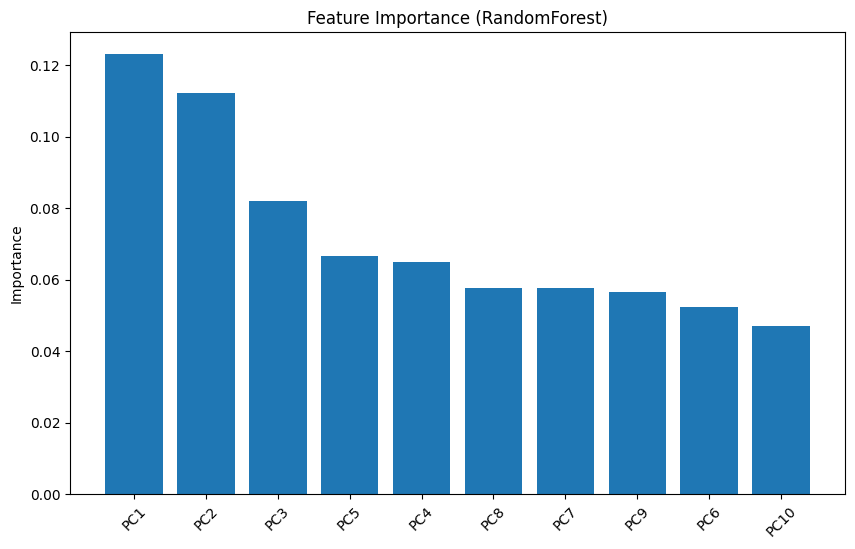

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# feature importance из RF
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # сортировка по убыванию

plt.figure(figsize=(10,6))
plt.title("Feature Importance (RandomForest)")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [pc_cols[i] for i in indices[:10]], rotation=45)
plt.ylabel("Importance")
plt.show()


In [ ]:
!pip -q install umap-learn
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Use the same X as for models (PC1..PC20). No leakage concerns for visualization.
X_umap = df[pc_cols].to_numpy(dtype="float32")
labels = df["Group"].to_numpy()

reducer = umap.UMAP(
    n_neighbors=30,      # try 15–50
    min_dist=0.1,        # try 0.0–0.5
    n_components=2,
    metric="euclidean",
    random_state=42
)
emb = reducer.fit_transform(X_umap)  # shape: (n_samples, 2)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


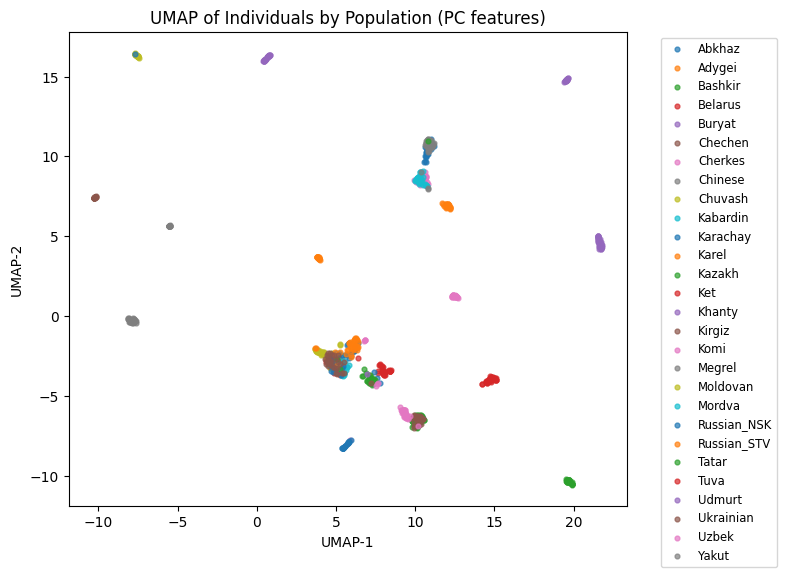

In [ ]:
plt.figure(figsize=(8,6))
for g in np.unique(labels):
    ix = labels == g
    plt.scatter(emb[ix,0], emb[ix,1], s=12, alpha=0.7, label=g)
plt.title("UMAP of Individuals by Population (PC features)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small", ncol=1)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


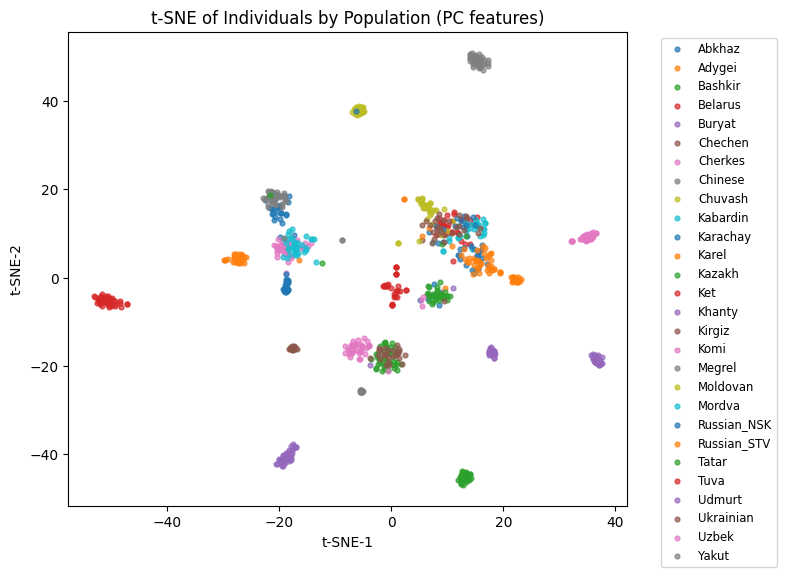

In [ ]:
# 1) Imports (sklearn already in Colab)
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# X = df[pc_cols].to_numpy(dtype="float32")   # you already have df and pc_cols
X_tsne_in = df[pc_cols].to_numpy(dtype="float32")
labels = df["Group"].to_numpy()

# 2) t-SNE embedding on PC features
tsne = TSNE(
    n_components=2,
    perplexity=30,     # try 20, 30, 40
    learning_rate="auto",
    init="pca",        # stable initialization
    n_iter=2000,
    random_state=42
)
emb_tsne = tsne.fit_transform(X_tsne_in)  # shape: (n_samples, 2)

# 3) Plot t-SNE (colored by population)
plt.figure(figsize=(8,6))
for g in np.unique(labels):
    idx = labels == g
    plt.scatter(emb_tsne[idx, 0], emb_tsne[idx, 1], s=12, alpha=0.7, label=g)
plt.title("t-SNE of Individuals by Population (PC features)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


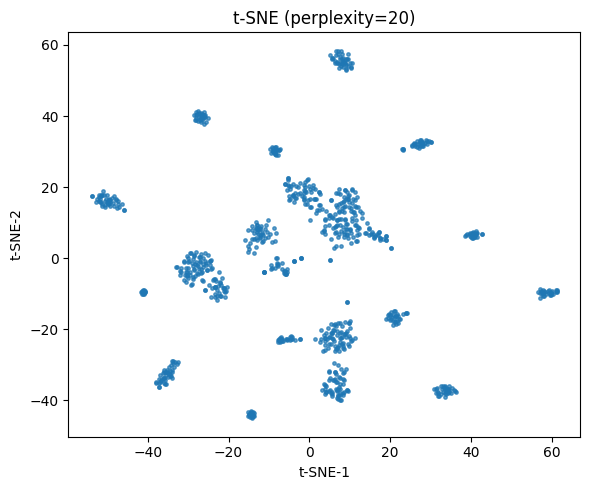

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


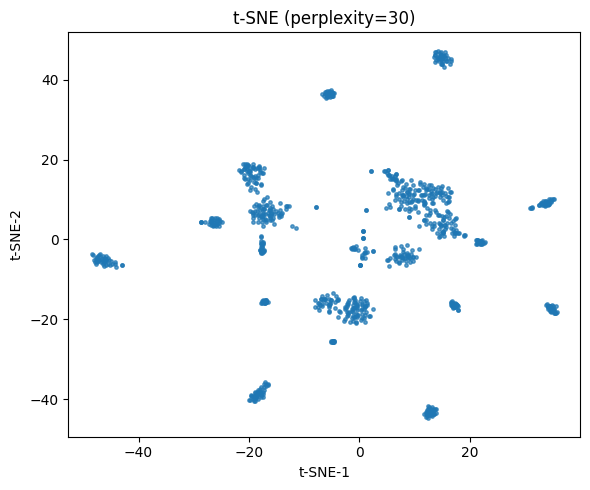

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


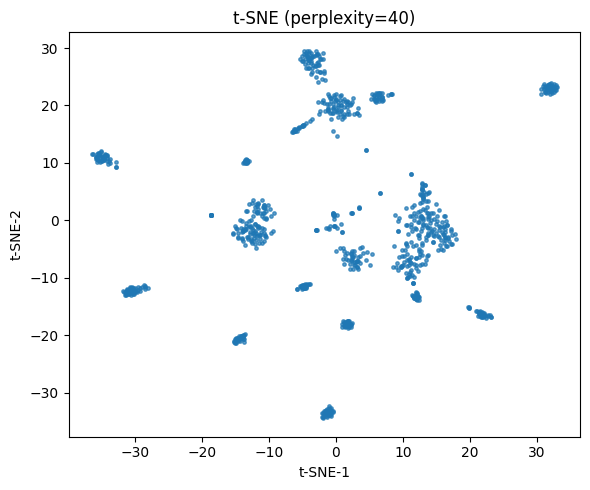

In [ ]:
for perplexity in (20, 30, 40):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto",
                init="pca", n_iter=1500, random_state=42)
    emb = tsne.fit_transform(X_tsne_in)
    plt.figure(figsize=(6,5))
    plt.scatter(emb[:,0], emb[:,1], s=6, alpha=0.7)
    plt.title(f"t-SNE (perplexity={perplexity})")
    plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Fine groups observed in your data:
# ['Abkhaz','Adygei','Bashkir','Belarus','Buryat','Chechen','Cherkes','Chinese','Chuvash',
#  'Kabardin','Karachay','Karel','Kazakh','Ket','Khanty','Kirgiz','Komi','Megrel','Moldovan',
#  'Mordva','Russian_NSK','Russian_STV','Tatar','Tuva','Udmurt','Ukrainian','Uzbek','Yakut']

super_map = {
    # Slavic
    'Belarus':'Slavic','Ukrainian':'Slavic','Moldovan':'Slavic',
    'Russian_NSK':'Slavic','Russian_STV':'Slavic',

    # Turkic (Volga + Central Asia + N Caucasus Turkic)
    'Bashkir':'Turkic','Tatar':'Turkic','Kazakh':'Turkic','Kirgiz':'Turkic',
    'Uzbek':'Turkic','Karachay':'Turkic','Chuvash':'Turkic',

    # North Caucasus (non-Turkic)
    'Abkhaz':'NorthCaucasus','Adygei':'NorthCaucasus','Chechen':'NorthCaucasus',
    'Cherkes':'NorthCaucasus','Kabardin':'NorthCaucasus',

    # Finno-Ugric (Uralic)
    'Karel':'FinnoUgric','Komi':'FinnoUgric','Udmurt':'FinnoUgric','Mordva':'FinnoUgric','Khanty':'FinnoUgric',

    # Siberian / Far-East natives
    'Yakut':'Siberian','Buryat':'Siberian','Tuva':'Siberian','Ket':'Siberian',

    # East Asian
    'Chinese':'EastAsian',

    # Georgian subgroup
    'Megrel':'Georgian',
}

df['SuperGroup'] = df['Group'].map(super_map).fillna('Other')
print(df['SuperGroup'].value_counts())


SuperGroup
Turkic           231
Slavic           166
Siberian         160
FinnoUgric       145
NorthCaucasus    143
Georgian          36
EastAsian         13
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


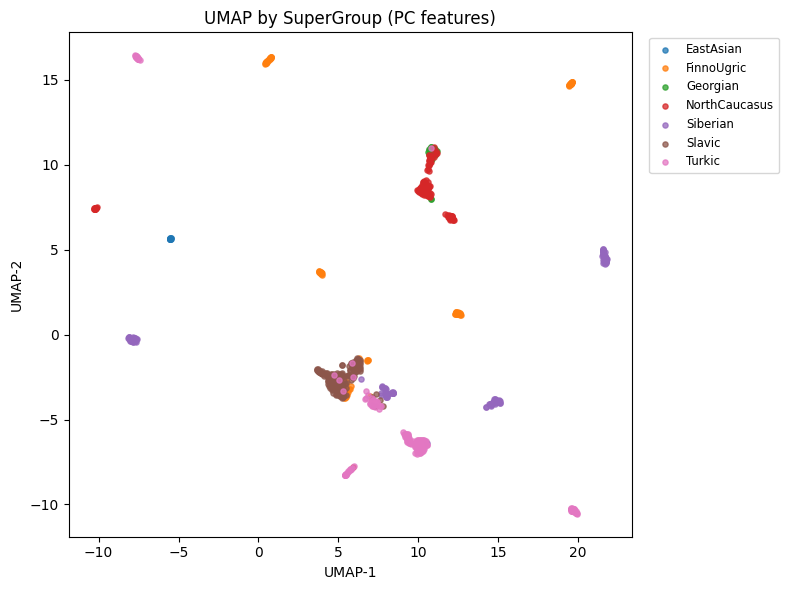

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

X_umap = df[pc_cols].to_numpy(dtype='float32')
sg = df['SuperGroup'].to_numpy()

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)
emb_umap = reducer.fit_transform(X_umap)

plt.figure(figsize=(8,6))
for g in np.unique(sg):
    idx = (sg == g)
    plt.scatter(emb_umap[idx,0], emb_umap[idx,1], s=14, alpha=0.75, label=g)
plt.title("UMAP by SuperGroup (PC features)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize="small")
plt.tight_layout(); plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


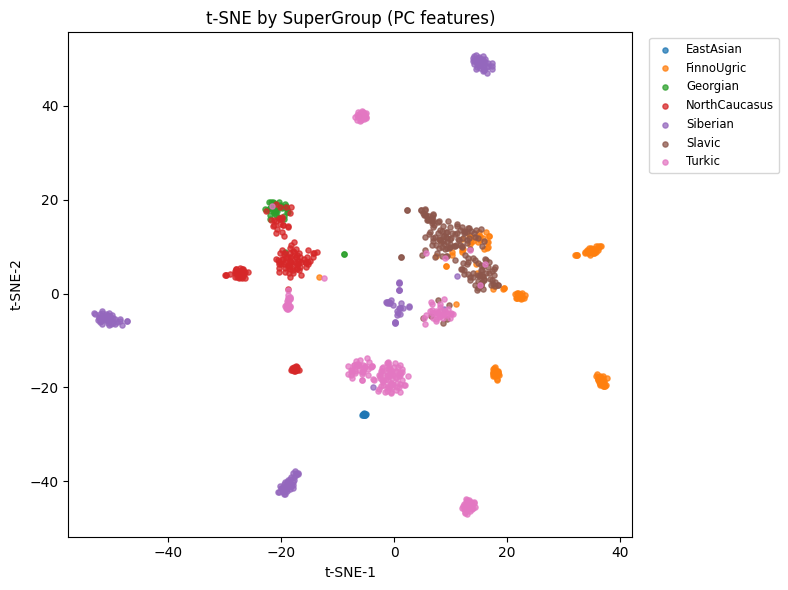

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca',
            n_iter=2000, random_state=42)
emb_tsne = tsne.fit_transform(X_umap)

plt.figure(figsize=(8,6))
for g in np.unique(sg):
    idx = (sg == g)
    plt.scatter(emb_tsne[idx,0], emb_tsne[idx,1], s=14, alpha=0.75, label=g)
plt.title("t-SNE by SuperGroup (PC features)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize="small")
plt.tight_layout(); plt.show()


In [ ]:
!pip -q install xgboost lightgbm


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

# PC features and labels
X = df[pc_cols].to_numpy(dtype="float32")
le = LabelEncoder()
y = le.fit_transform(df["Group"].to_numpy())

# Split once for final reports
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

xgb_acc = cross_val_score(xgb, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_f1  = cross_val_score(xgb, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"XGBoost CV  | acc: {xgb_acc.mean():.3f} ± {xgb_acc.std():.3f} | F1: {xgb_f1.mean():.3f} ± {xgb_f1.std():.3f}")

# Train/test
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\n=== XGBoost test report ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f} | Macro-F1: {f1_score(y_test, y_pred_xgb, average='macro'):.3f}")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))


XGBoost CV  | acc: 0.859 ± 0.038 | F1: 0.865 ± 0.035

=== XGBoost test report ===
Accuracy: 0.844 | Macro-F1: 0.852
              precision    recall  f1-score   support

      Abkhaz       0.83      1.00      0.91         5
      Adygei       1.00      1.00      1.00         6
     Bashkir       1.00      1.00      1.00         7
     Belarus       0.71      0.83      0.77         6
      Buryat       1.00      0.89      0.94         9
     Chechen       1.00      1.00      1.00         3
     Cherkes       0.62      0.71      0.67         7
     Chinese       1.00      1.00      1.00         2
     Chuvash       1.00      1.00      1.00         6
    Kabardin       0.71      0.71      0.71         7
    Karachay       1.00      1.00      1.00         4
       Karel       1.00      0.80      0.89         5
      Kazakh       0.67      0.89      0.76         9
         Ket       1.00      1.00      1.00         6
      Khanty       1.00      1.00      1.00         6
      Kirgiz       

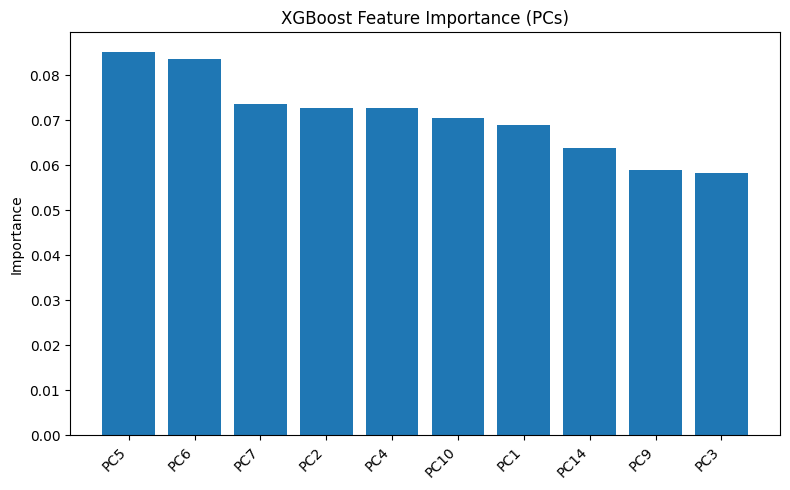

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_importances(model, title, topk=10):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:topk]
    plt.figure(figsize=(8,5))
    plt.bar(range(topk), importances[idx])
    plt.xticks(range(topk), [pc_cols[i] for i in idx], rotation=45, ha="right")
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_importances(xgb, "XGBoost Feature Importance (PCs)")



In [ ]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

summary = pd.DataFrame([
    ["XGBoost",    accuracy_score(y_test, y_pred_xgb),  f1_score(y_test, y_pred_xgb,  average="macro")],

    ["RandomForest",accuracy_score(y_test, rf_pred),     f1_score(y_test, rf_pred,     average="macro")],
], columns=["Model","Test Accuracy","Test Macro-F1"])
summary


,Model,Test Accuracy,Test Macro-F1
0,XGBoost,0.843575,0.85241
1,RandomForest,0.860335,0.86862


In [ ]:
# X, y_enc, le already defined in your notebook (PC features + labels)
# If not:
# X = df[pc_cols].to_numpy(dtype="float32")
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder(); y_enc = le.fit_transform(df["Group"].to_numpy())

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Train/test split (fixed to evaluate final best model)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_enc)),
    tree_method="hist",          # change to "gpu_hist" if you enable GPU
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=1200            # high, we’ll let learning_rate + depth regularize
)

param_distributions = {
    "learning_rate":    np.logspace(-2.2, -0.7, 12),   # ~0.006–0.2
    "max_depth":        [3,4,5,6,7,8],
    "min_child_weight": [1,2,3,5,7],
    "subsample":        [0.6,0.7,0.8,0.9,1.0],
    "colsample_bytree": [0.6,0.7,0.8,0.9,1.0],
    "gamma":            [0, 0.5, 1.0],
    "reg_alpha":        [0, 1e-3, 1e-2, 1e-1],
    "reg_lambda":       [0.5, 1.0, 1.5, 2.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,                    # bump to 80+ if you have time
    scoring="f1_macro",           # robust to class imbalance
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,                   # refit on full training set with best params
    random_state=42
)

search.fit(X_train, y_train)
print("Best CV macro-F1:", search.best_score_)
print("Best params:", search.best_params_)

best_xgb = search.best_estimator_
y_pred = best_xgb.predict(X_test)
print("\n=== XGBoost (tuned) — test set ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f} | Macro-F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV macro-F1: 0.8533139106458435
Best params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': np.float64(0.10648114862349344), 'gamma': 1.0, 'colsample_bytree': 0.8}

=== XGBoost (tuned) — test set ===
Accuracy: 0.860 | Macro-F1: 0.866
              precision    recall  f1-score   support

      Abkhaz       0.83      1.00      0.91         5
      Adygei       1.00      1.00      1.00         6
     Bashkir       1.00      1.00      1.00         7
     Belarus       0.83      0.83      0.83         6
      Buryat       1.00      0.89      0.94         9
     Chechen       1.00      1.00      1.00         3
     Cherkes       0.60      0.43      0.50         7
     Chinese       1.00      1.00      1.00         2
     Chuvash       1.00      1.00      1.00         6
    Kabardin       0.60      0.86      0.71         7
    Karachay       1.00      1.00      